<a href="https://colab.research.google.com/github/rodrigorochag/CNN_Classifier_Pytorch/blob/main/animals_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import random
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
import os

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
# Install the Kaggle library
!pip install -q kaggle

# Set Kaggle credentials
import json
import os

# Replace the following with your Kaggle username and API key

kaggle_info = {
    "username": "user_kaggle",
    "key": "api_key"
}
# Save Kaggle credentials to a JSON file
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(kaggle_info, file)

# Change the permissions of the file
!chmod 600 /root/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d andrewmvd/animal-faces
# Unzip the dataset
!unzip -q /content/animal-faces.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 97% 673M/696M [00:07<00:00, 130MB/s]
100% 696M/696M [00:07<00:00, 99.3MB/s]


In [3]:
train_dataset = '/content/afhq/train'
validation_dataset = '/content/afhq/val'
test_size = 2000

In [4]:
train_dataset = ImageFolder(train_dataset,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

validation_dataset = ImageFolder(validation_dataset,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [40]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: /content/afhq/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [41]:
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of Val Data : {len(validation_dataset)}")

Length of Train Data : 14630
Length of Val Data : 1500


In [42]:
print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['cat', 'dog', 'wild']


Label : cat


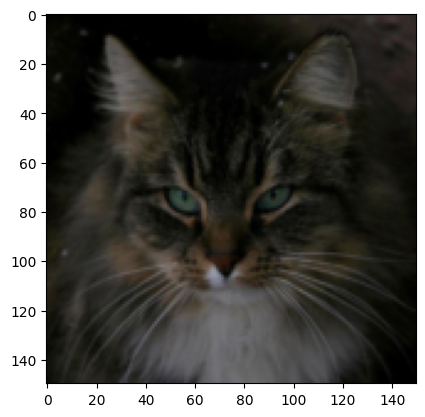

In [43]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[0])

O dataset possui apenas train e val, faltando test. É necessário dar split e gerar dataset para teste

In [5]:
batch_size = 128
test_size = 1500
train_size = len(train_dataset) - test_size

train_dataset,test_dataset = random_split(train_dataset,[train_size,test_size])
print(f"Length of Train dataset : {len(train_dataset)}")
print(f"Length of Test dataset : {len(test_dataset)}")
print(f"Length of Validation dataset: {len(validation_dataset)}")


#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(validation_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train dataset : 13130
Length of Test dataset : 1500
Length of Validation dataset: 1500


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
train_dataset
# <torch.utils.data.dataset.Subset> é uma classe do PyTorch que permite criar subconjuntos de dados a partir de um dataset existente.

In [47]:
train_dl

# <torch.utils.data.dataloader.DataLoader> é uma classe fundamental do PyTorch que facilita o carregamento e gerenciamento de datasets.
# Ele é responsável por iterar sobre um dataset e entregar os dados em lotes (minibatches) para o treinamento ou avaliação de modelos de machine learning, de maneira eficiente.


Imagens salvas no batch (128)

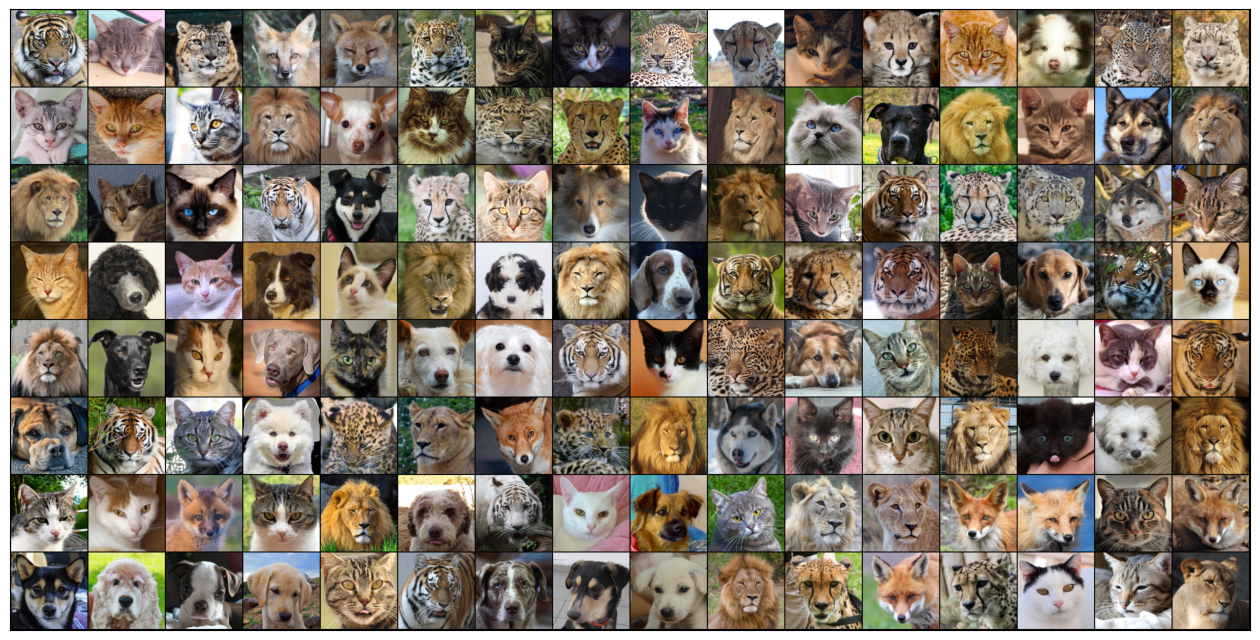

In [6]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [7]:
class AnimalWildCNN(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [8]:
class NaturalSceneClassification(AnimalWildCNN):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )

    def forward(self, xb):
        return self.network(xb)

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [10]:
model = NaturalSceneClassification()
model

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [11]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

Model fitting

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [15]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [16]:
#initial evaluation of the model
evaluate(model,val_dl)

{'val_loss': 1.7939748764038086, 'val_acc': 0.0}

In [17]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.2760, val_loss: 1.0115, val_acc: 0.4846
Epoch [1], train_loss: 0.7436, val_loss: 0.5950, val_acc: 0.7532
Epoch [2], train_loss: 0.4400, val_loss: 0.3187, val_acc: 0.8807
Epoch [3], train_loss: 0.2494, val_loss: 0.2269, val_acc: 0.9114
Epoch [4], train_loss: 0.1512, val_loss: 0.1957, val_acc: 0.9273
Epoch [5], train_loss: 0.1020, val_loss: 0.1634, val_acc: 0.9434
Epoch [6], train_loss: 0.0627, val_loss: 0.1632, val_acc: 0.9435
Epoch [7], train_loss: 0.0433, val_loss: 0.1821, val_acc: 0.9336
Epoch [8], train_loss: 0.0337, val_loss: 0.1694, val_acc: 0.9515
Epoch [9], train_loss: 0.0219, val_loss: 0.1300, val_acc: 0.9566
Epoch [10], train_loss: 0.0088, val_loss: 0.1762, val_acc: 0.9561
Epoch [11], train_loss: 0.0137, val_loss: 0.1856, val_acc: 0.9558
Epoch [12], train_loss: 0.0174, val_loss: 0.1834, val_acc: 0.9573
Epoch [13], train_loss: 0.0117, val_loss: 0.1681, val_acc: 0.9654
Epoch [14], train_loss: 0.0112, val_loss: 0.1679, val_acc: 0.9566
Epoch [15], train_lo

Model Accuracy and Losses

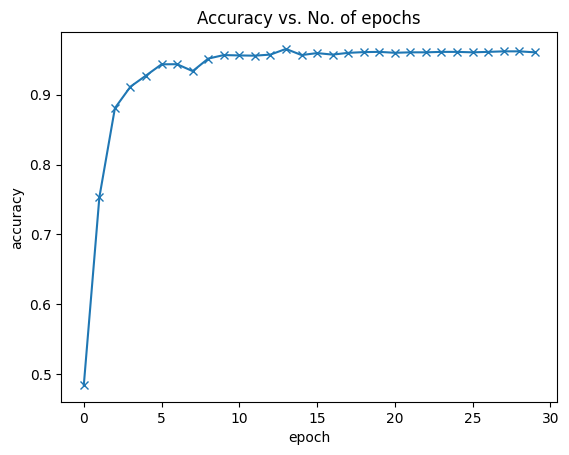

In [18]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');


plot_accuracies(history)

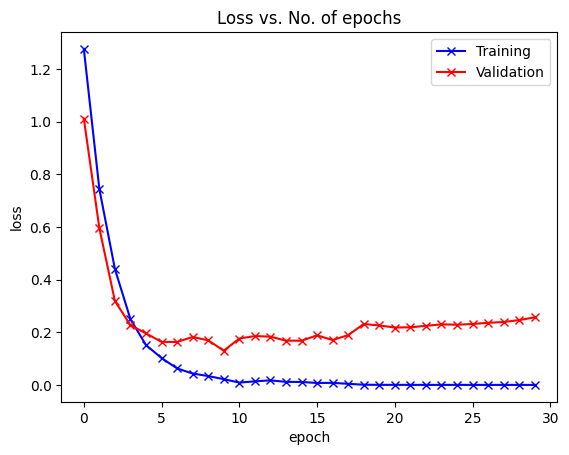

In [19]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [20]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.2973693013191223, 'val_acc': 0.9618134498596191}

In [21]:
#save the model
torch.save(model.state_dict(), 'natural-scene-classification.pth')

In [23]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_dataset.classes[preds[0].item()]